# Twitter Data Analysis
### 1. User entity analysis for 5 most active users
### 2. Hashtag entity analysis for 5 most popular hashtags
### 3. Tweet entity analysis for five most prevalent topics in the tweets

##### Importing required packages

In [1]:
import snscrape.modules.twitter as sntwitter
from datetime import datetime, date, timedelta

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import pyLDAvis
import pyLDAvis.sklearn

#pip install pyLDAvis

import warnings
warnings.filterwarnings('ignore')


C:\Users\sahma\miniconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Creating some dynamic parametere for scraper query 

In [2]:
#start_date = date.today()
#end_date = start_date - timedelta(days=7) #1 week tweet data to scrape
#language = 'en'
#city = 'hannover' #here any other city can be selected like berlin, paris etc
#query = f'near:"{city}" within:20km lang:{language} since:{end_date} until:{start_date}'
#tweets = []
#limit = 4500 #this limit can be increased

In [2]:
#print(start_date)
#print(end_date)

###  Extracting data from twitter by using snscrape 

###### 1. Looping through each tweet and getting items like username, content, hashtags and location
###### 2. Appending data to predefined empty tweets list 

In [3]:
#for tweet in sntwitter.TwitterSearchScraper(query).get_items():
#    if len(tweets) == limit:
#        break
#    else:
#        tweets.append([tweet.user.username, tweet.content, tweet.hashtags, tweet.user.location])

##### Creating a dataframe with following columns 
1. user
2. tweet
3. hashtag
4. location

In [4]:
#df = pd.DataFrame(tweets, columns=['user', 'tweet', 'hashtag', 'location'])

##### Writing extracted data to a csv file with dynamic file name 

In [5]:
#df.to_csv(f'{city}-tweets.csv', index=False, encoding='utf8')

##### We extracted 4500 tweets with 4 columns, confirmed by reading csv file row numbers

In [6]:
df = pd.read_csv('hannover-tweets.csv')
df.shape 

(4500, 4)

##### Droping tweets which dosn't contain hashtags, for this analyis we will use only tweets data with hashtags.

In [7]:
df = df.dropna(subset = ['hashtag'])
df.shape

(454, 4)

##### After droping none hashtag tweets we left with 454 tweets data


##### A view of data frame 

In [8]:
df.tail(10)

,user,tweet,hashtag,location
4348,GofERabbbit,UN #Biodiversity2022 Conference #Guterres and ...,"['Biodiversity2022', 'Guterres', 'WEF', 'Agend...","Hannover, Deutschland"
4349,br_ricke,Good Morning #NateNerds !\n\nNever underestima...,"['NateNerds', 'NathanFillion', 'TheRookie', 'C...",Germany
4350,germannateclub,Happy Tuesday #Fillionaires &amp; #Browncoats ...,"['Fillionaires', 'Browncoats', 'NathanFillion'...",Deutschland
4424,profi_youth,This is so sad.\n\nTerry Hall was the self-ass...,['Specials'],Hannover
4436,janniswiese,"Hey @elonmusk, honest question: Will we actual...",['twitterfiles'],"Hanover, Lower Saxony"
4443,janniswiese,@fools_n_kings @KimDotcom The whole story woul...,['kimdottinfoilhat'],"Hanover, Lower Saxony"
4467,mariachaboart,Christkind Group by Maria Chabo\n▫️All About E...,"['jesus', 'prayer', 'jesuschrist', 'jesusilove...","Hannover, Deutschland"
4468,jesusiloveyouen,Christkind Group by Maria Chabo\n▫️All About E...,"['jesus', 'prayer', 'jesuschrist', 'jesusilove...","Hannover, Deutschland"
4476,mal1iii,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,['GiftRTX'],"Hannover, Deutschland"
4485,enfiesta14,"""Withdraw the amendment. Same dogs, same law. ...",['NoLosExcluyasPsoe'],"Hannover, Deutschland"


# 1. User entity analysis for 5 most active users

### By using user column and NLTK frequency distrubution function to count user tweets per user


In [9]:
users = df['user']
freq = nltk.FreqDist(users)
d = pd.DataFrame({'UserName': list(freq.keys()),
                 'TweetsCount': list(freq.values())})
d = d.nlargest(columns='TweetsCount', n=5)
print(d)

           UserName  TweetsCount
14  stephenmorris84           28
24  rockdaspotagent           22
10   caoimhin_craig           16
70       ArndtVogel           14
42          MC_Floh           12


#### As data shows most active user is stephenmorris84 with 28 tweets
#### Ploting most active user result with seaborn bar chart and save as .png file

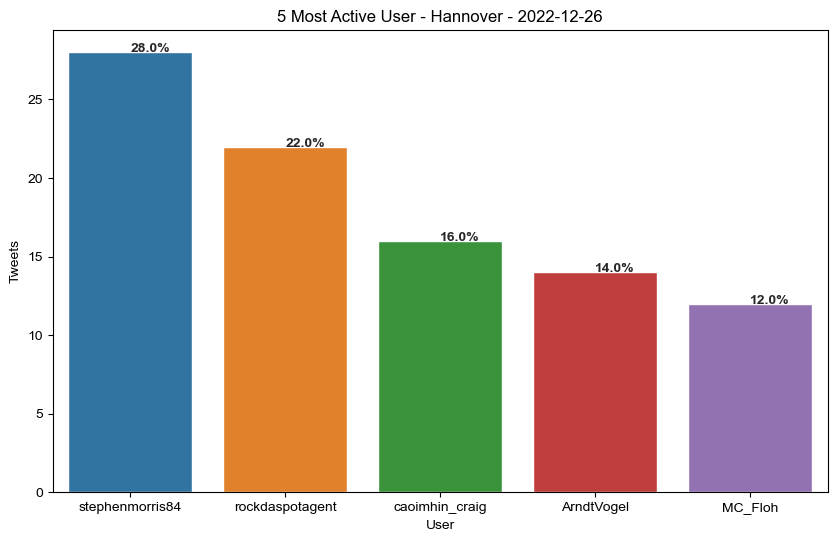

In [10]:

bar,ax = plt.subplots(figsize=(10,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=d, x='UserName', y='TweetsCount')
ax.set_title('5 Most Active User - Hannover - 2022-12-26', fontsize=12)
ax.set_xlabel ("User")
ax.set_ylabel ("Tweets")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),"%.1f%%"% rect.get_height(), weight='bold' )
plt.show()
bar.savefig("MostActiveUser")


# 2. Hashtag entity analysis for 5 most popular hashtags

#### Converting hashtag data to string an lower case

In [11]:
def hashtag_extract(hashtags):  
    hashtags = str(hashtags).lower()
    return hashtags

#### Applying hashtag_extract function to hashtag dataframe

In [12]:
df['hashtags_txt'] = df['hashtag'].apply(hashtag_extract)

#### Further cleaning on hashtags text data

In [13]:
hashtag_to_text = df['hashtags_txt'].values
hashtag_to_text = str(hashtag_to_text)
hashtag_to_text = re.sub(r' indices', ' ', hashtag_to_text)
hashtag_to_text = re.sub(r' text', ' ', hashtag_to_text) 
hashtag_to_text = re.sub(r'[^a-z A-Z]', ' ', hashtag_to_text)
hashtag_to_text = re.sub(r' +', ' ', hashtag_to_text)

In [14]:
#print(hashtag_to_text)

#### Function to count each word in hashtag text 

In [15]:
def counter(text):
    counts = dict()
    words = text.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

#### Appling counter function to hashtag_to_text data 

In [16]:
hashtags = counter(hashtag_to_text)

### By using hashtags data and NLTK frequency distrubution function to count each tweet occurences

In [17]:
freq = nltk.FreqDist(hashtags)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d = d.nlargest(columns='Count', n=5)
print(d)

        Hashtag  Count
37        aiart     29
38    nightcafe     27
39   digitalart     27
189      shorts     19
229  mariachabo     19


#### As data shows most popular hashtag is aiart 29 time occurences
#### Ploting most frequently used hashtag with seaborn bar chart and save as .png file

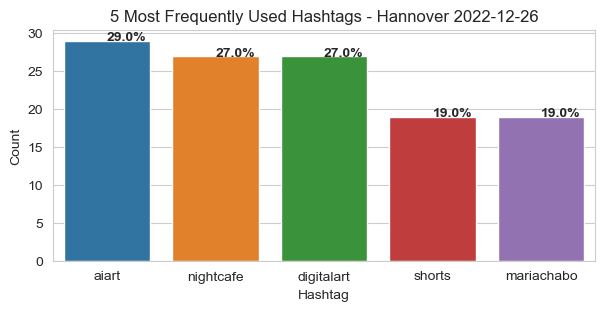

In [18]:
bar,ax = plt.subplots(figsize=(7,3))
sns.set_style("whitegrid")
ax = sns.barplot(data=d, x='Hashtag', y='Count')
ax.set_title('5 Most Frequently Used Hashtags - Hannover 2022-12-26', fontsize=12)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),"%.1f%%"% rect.get_height(), weight='bold' )
plt.show()
bar.savefig("PopularHashtag")

# 3. Tweet entity analysis for five most prevalent topics in the tweets

### 3.1 Converting tweets data to string and lower case 

In [19]:
def tweet_to_text(tweet):   
    tweet = str(tweet).lower() #Make the text lowercase.
    return tweet
df['tweet_stage_1'] = df['tweet'].apply(tweet_to_text)   

In [20]:
text_tweets = df[['tweet', 'tweet_stage_1']]
text_tweets.tail()

,tweet,tweet_stage_1
4443,@fools_n_kings @KimDotcom The whole story woul...,@fools_n_kings @kimdotcom the whole story woul...
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,@nvidiageforce @yeah_jul #giftrtx more power
4485,"""Withdraw the amendment. Same dogs, same law. ...","""withdraw the amendment. same dogs, same law. ..."


### 3.2 Removing none characters elements such as usernames, urls etc. from tweets data
    

In [21]:
def tweet_cleaning(tweet):
    tweet = re.sub(r'[^a-z A-Z]', ' ',tweet) #Remove all not characters
    tweet = re.sub(r'@[A-Za-z0–9]+', '',tweet) #remove usernames 
    tweet = re.sub(r'@\w+', ' ', tweet) #remove usernames
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) #remove website
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)  #remove all websites
    tweet = re.sub(r'http\S+', ' ', tweet) #remove all Url
    tweet = re.sub(r'#[A-Za-z0–9]+', '', tweet) #remove hashtags
    tweet = re.sub(r'\b\w{1}\b', '', tweet) #remove stopwords
    tweet = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', tweet)
    tweet = re.sub(r'&amp', '', tweet)
    tweet = re.sub('\n', '', tweet) #Remove line breaks.
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) #remove punctuation
    tweet = re.sub('\[.*?\]', '', tweet) 
    tweet = re.sub(r' +', ' ', tweet) #remove extra space
    tweets = re.sub('<.*?>+', '', tweet) 
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)  
    return tweet

In [22]:
df['tweet_stage_2'] = df['tweet_stage_1'].apply(tweet_cleaning)

In [23]:
clean_tweets = df[['tweet', 'tweet_stage_1', 'tweet_stage_2']]
clean_tweets.tail()

,tweet,tweet_stage_1,tweet_stage_2
4443,@fools_n_kings @KimDotcom The whole story woul...,@fools_n_kings @kimdotcom the whole story woul...,fools kings kimdotcom the whole story would f...
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,@nvidiageforce @yeah_jul #giftrtx more power,nvidiageforce yeah jul giftrtx more power
4485,"""Withdraw the amendment. Same dogs, same law. ...","""withdraw the amendment. same dogs, same law. ...",withdraw the amendment same dogs same law no ...


### 3.3 Removing stopwords from tweets data by using NLTK stopwords functionality

In [24]:
stopwords = nltk.corpus.stopwords.words('english') 
df['tweet_stage_3'] = df['tweet_stage_2'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stopwords))

tweet_without_stopwords =df[['tweet','tweet_stage_1','tweet_stage_2','tweet_stage_3']]
tweet_without_stopwords.tail()

,tweet,tweet_stage_1,tweet_stage_2,tweet_stage_3
4443,@fools_n_kings @KimDotcom The whole story woul...,@fools_n_kings @kimdotcom the whole story woul...,fools kings kimdotcom the whole story would f...,fools kings kimdotcom whole story would fit na...
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co xac ps ins...
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co qnthpekcj ...
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,@nvidiageforce @yeah_jul #giftrtx more power,nvidiageforce yeah jul giftrtx more power,nvidiageforce yeah jul giftrtx power
4485,"""Withdraw the amendment. Same dogs, same law. ...","""withdraw the amendment. same dogs, same law. ...",withdraw the amendment same dogs same law no ...,withdraw amendment dogs law animal abuse senti...


### 3.4 Stemming tweets data with NLTK PorterStemmer

In [25]:
stemmer = PorterStemmer()
df['tweet_stage_4'] = df['tweet_stage_3'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

tweet_after_stemming = df[['tweet','tweet_stage_1','tweet_stage_2','tweet_stage_3', 'tweet_stage_4']]
tweet_after_stemming.tail()

,tweet,tweet_stage_1,tweet_stage_2,tweet_stage_3,tweet_stage_4
4443,@fools_n_kings @KimDotcom The whole story woul...,@fools_n_kings @kimdotcom the whole story woul...,fools kings kimdotcom the whole story would f...,fools kings kimdotcom whole story would fit na...,fool king kimdotcom whole stori would fit narr...
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co xac ps ins...,christkind group maria chabo eve co xac ps ins...
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co qnthpekcj ...,christkind group maria chabo eve co qnthpekcj ...
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,@nvidiageforce @yeah_jul #giftrtx more power,nvidiageforce yeah jul giftrtx more power,nvidiageforce yeah jul giftrtx power,nvidiageforc yeah jul giftrtx power
4485,"""Withdraw the amendment. Same dogs, same law. ...","""withdraw the amendment. same dogs, same law. ...",withdraw the amendment same dogs same law no ...,withdraw amendment dogs law animal abuse senti...,withdraw amend dog law anim abus sentient live...


### 3.5 Lemmatizing tweets data with NLTK WordNetLemmatizer
##### Lemitizing convert word to its base form, for example played  will be convert to play, reading will be read etc.

In [26]:
lemmatizer = WordNetLemmatizer()
df['tweet_stage_final'] = df['tweet_stage_4'].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
tweet_after_lemmatizing = df[['tweet','tweet_stage_1','tweet_stage_2','tweet_stage_3', 'tweet_stage_4', 'tweet_stage_final']]
tweet_after_lemmatizing.tail()

,tweet,tweet_stage_1,tweet_stage_2,tweet_stage_3,tweet_stage_4,tweet_stage_final
4443,@fools_n_kings @KimDotcom The whole story woul...,@fools_n_kings @kimdotcom the whole story woul...,fools kings kimdotcom the whole story would f...,fools kings kimdotcom whole story would fit na...,fool king kimdotcom whole stori would fit narr...,fool king kimdotcom whole stori would fit narr...
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co xac ps ins...,christkind group maria chabo eve co xac ps ins...,christkind group maria chabo eve co xac p inst...
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group by maria chabo\n▫️all about e...,christkind group by maria chabo all about eve ...,christkind group maria chabo eve co qnthpekcj ...,christkind group maria chabo eve co qnthpekcj ...,christkind group maria chabo eve co qnthpekcj ...
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,@nvidiageforce @yeah_jul #giftrtx more power,nvidiageforce yeah jul giftrtx more power,nvidiageforce yeah jul giftrtx power,nvidiageforc yeah jul giftrtx power,nvidiageforc yeah jul giftrtx power
4485,"""Withdraw the amendment. Same dogs, same law. ...","""withdraw the amendment. same dogs, same law. ...",withdraw the amendment same dogs same law no ...,withdraw amendment dogs law animal abuse senti...,withdraw amend dog law anim abus sentient live...,withdraw amend dog law anim abus sentient live...


### 3.6 Vectorizing tweets data by using CountVectorizer with ngrame_range (1,3) mean  unigrams, bigrams, and trigrams.

In [27]:
vectorizer = CountVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3),stop_words='english')
count_vector_tweet = vectorizer.fit_transform(df['tweet_stage_final'])
count_vector_tweet.shape

(454, 12668)

### 3.7 Vectorizing tweets data by using TF-IDF with ngram_range (1,3) mean unigrams, bigrams, and trigrams.

In [28]:
tf_idf = TfidfVectorizer(min_df=1 ,max_df=0.95, ngram_range=(1,3),stop_words='english')
tf_idf_tweet = tf_idf.fit_transform(df['tweet_stage_final'])
tf_idf_tweet.shape

(454, 12668)

## 3.8 Topic modeling by using Latent Dirichlet Allocation (LDA) with CountVectorizer

In [29]:
LDA_with_CountVector = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_with_CountVector.fit(count_vector_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [30]:
LDA_with_CountVector.components_

array([[0.20000122, 1.20019062, 1.19999818, ..., 1.19999818, 0.20000076,
        0.20000076],
       [0.20000144, 0.20000252, 0.20000047, ..., 0.20000047, 1.19999667,
        1.19999667],
       [0.20000134, 0.20000232, 0.20000043, ..., 0.20000043, 0.20000082,
        0.20000082],
       [0.20000136, 1.19980203, 0.20000045, ..., 0.20000045, 0.20000084,
        0.20000084],
       [1.19999464, 0.20000251, 0.20000047, ..., 0.20000047, 0.20000092,
        0.20000092]])

In [31]:
#topic = LDA_with_CountVector.components_[0]
#topic.argsort()

In [32]:
#len(topic)

In [33]:
# Top 10 words for topic [2]:
#topic[4]
#topic.argsort()[-10:]

In [34]:
#Printing 10 words for topic [4]:
#top_words_in_topic = topic.argsort()[-10:]
#for index in top_words_in_topic:
#    print(vectorizer.get_feature_names()[index])

In [35]:
for index,topic in enumerate(LDA_with_CountVector.components_):
    print(f'Topic {index}'+ ': ')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])

Topic 0: 
['christianwomen', 'group', 'cm', 'eve', 'share', 'youtub', 'amp', 'vintag', 'etsi', 'christian']
Topic 1: 
['aiart nightcaf', 'nightcaf digitalart', 'aiart nightcaf digitalart', 'nightcafestudio', 'digitalart', 'aiart', 'thank', 'new', 'youtub', 'year']
Topic 2: 
['allabouteveshop christian influenc', 'christian influenc jewelri', 'allabouteveshop christian', 'insta', 'influenc jewelri', 'influenc', 'maria chabo', 'eve', 'christian', 'group']
Topic 3: 
['aprn', 'ritschi', 'castl firefli', 'therooki castl firefli', 'firefli', 'therooki', 'firefli chrissychatt', 'nathanfillion therooki', 'happi', 'castl']
Topic 4: 
['happi', 'digitalart', 'nightcafestudio', 'aiart nightcaf digitalart', 'nightcaf digitalart', 'aiart nightcaf', 'nightcaf', 'aiart', 'christma', 'year']


### 3.8.1Tweets and their corresponding Topics by using LDA with CountVector 

In [36]:
LDA_CountVector_Topic = LDA_with_CountVector.transform(count_vector_tweet)
LDA_CountVector_Topic[0].argmax()
LDA_CountVector_Topic.argmax(axis=1)
df['LDA_CountVector_Topic'] = LDA_CountVector_Topic.argmax(axis=1)
df[['tweet','tweet_stage_final', 'LDA_CountVector_Topic']].tail(10)

,tweet,tweet_stage_final,LDA_CountVector_Topic
4348,UN #Biodiversity2022 Conference #Guterres and ...,un biodivers confer guterr wef agenda klaussch...,3
4349,Good Morning #NateNerds !\n\nNever underestima...,good morn natenerd never underestim power hope...,2
4350,Happy Tuesday #Fillionaires &amp; #Browncoats ...,happi tuesday fillionair amp browncoat amaz sh...,3
4424,This is so sad.\n\nTerry Hall was the self-ass...,sad terri hall self assur eye special storm co...,2
4436,"Hey @elonmusk, honest question: Will we actual...",hey elonmusk honest question actual get twitte...,4
4443,@fools_n_kings @KimDotcom The whole story woul...,fool king kimdotcom whole stori would fit narr...,4
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co xac p inst...,0
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co qnthpekcj ...,0
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,nvidiageforc yeah jul giftrtx power,3
4485,"""Withdraw the amendment. Same dogs, same law. ...",withdraw amend dog law anim abus sentient live...,3


## 3.9 Topic modeling by using Latent Dirichlet Allocation (LDA) with TF_IDF

In [37]:
LDA_with_tfidf = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_with_tfidf.fit(tf_idf_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [38]:
LDA_with_tfidf.components_

array([[0.20001339, 0.30379863, 0.31087331, ..., 0.31087331, 0.20001244,
        0.20001244],
       [0.2000142 , 0.20002586, 0.20000986, ..., 0.20000986, 0.36261588,
        0.36261588],
       [0.20001378, 0.20002515, 0.20000959, ..., 0.20000959, 0.20001267,
        0.20001267],
       [0.20001356, 0.20002498, 0.20000959, ..., 0.20000959, 0.20001259,
        0.20001259],
       [0.40573514, 0.42162679, 0.20001004, ..., 0.20001004, 0.20001337,
        0.20001337]])

In [39]:
topic = LDA_with_tfidf.components_[0]
topic.argsort()

array([ 1626,   559,  3999, ...,  2074, 11793,  3445], dtype=int64)

In [40]:
for index,topic in enumerate(LDA_with_tfidf.components_):
    print(f'Topic {index}'+ ': ')
    print([tf_idf.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Topic 0: 
['share makeitmeaning', 'handmad cushion', 'christma', 'cover', 'youtub', 'holiday', 'share', 'cm', 'vintag', 'etsi']
Topic 1: 
['merrychristma', 'thank', 'christma', 'azur', 'spi famili', 'spi', 'happi', 'new', 'like', 'year']
Topic 2: 
['christkind group maria', 'mariachabo', 'christlichefrauen', 'christlichefrauen mariachabo', 'njpw njwk', 'njwk', 'njpwworld', 'njpw njwk njpwworld', 'njwk njpwworld', 'njpw']
Topic 3: 
['group maria', 'maria chabo eve', 'maria chabo', 'maria', 'influenc', 'christian influenc', 'insta allabouteveshop', 'group', 'castl', 'christian']
Topic 4: 
['digitalart', 'nightcafestudio', 'aiart nightcaf', 'nightcaf', 'nightcaf digitalart', 'merri', 'merri christma', 'aiart', 'year', 'christma']


### 3.9.1Tweets and their corresponding Topics by using LDA with TF-IDF

In [41]:
LDA_TFIDF_Topic = LDA_with_tfidf.transform(tf_idf_tweet)
LDA_TFIDF_Topic[0].argmax()
LDA_TFIDF_Topic.argmax(axis=1)
df['LDA_TFIDF_Topic'] = LDA_TFIDF_Topic.argmax(axis=1)
df[['tweet','tweet_stage_final','LDA_TFIDF_Topic']].tail(10)


,tweet,tweet_stage_final,LDA_TFIDF_Topic
4348,UN #Biodiversity2022 Conference #Guterres and ...,un biodivers confer guterr wef agenda klaussch...,0
4349,Good Morning #NateNerds !\n\nNever underestima...,good morn natenerd never underestim power hope...,2
4350,Happy Tuesday #Fillionaires &amp; #Browncoats ...,happi tuesday fillionair amp browncoat amaz sh...,3
4424,This is so sad.\n\nTerry Hall was the self-ass...,sad terri hall self assur eye special storm co...,2
4436,"Hey @elonmusk, honest question: Will we actual...",hey elonmusk honest question actual get twitte...,4
4443,@fools_n_kings @KimDotcom The whole story woul...,fool king kimdotcom whole stori would fit narr...,4
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co xac p inst...,3
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co qnthpekcj ...,3
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,nvidiageforc yeah jul giftrtx power,3
4485,"""Withdraw the amendment. Same dogs, same law. ...",withdraw amend dog law anim abus sentient live...,3


## 3.10 Topic modeling by using Non-Negative Matric Factorization (NMF) with CountVector

In [42]:
NMF_with_CountVector = NMF(n_components=5, random_state=42) 
NMF_with_CountVector.fit(count_vector_tweet) 


NMF(n_components=5, random_state=42)

In [43]:
NMF_with_CountVector.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00473414e-05, 1.00643318e-05, ...,
        1.00643318e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.37637369e-03, 1.37438361e-03, ...,
        1.37438361e-03, 4.13866581e-04, 4.13866581e-04],
       [0.00000000e+00, 1.40298427e-06, 1.40950197e-06, ...,
        1.40950197e-06, 0.00000000e+00, 0.00000000e+00],
       [5.13376542e-04, 3.75244334e-03, 3.73456032e-03, ...,
        3.73456032e-03, 8.71679403e-03, 8.71679403e-03]])

In [44]:
for index,topic in enumerate(NMF_with_CountVector.components_):
    print(f'Topic {index}'+ ': ')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Topic 0: 
['chabo', 'christian influenc', 'allabouteveshop', 'allabouteveshop christian', 'chabo eve', 'allabouteveshop christian influenc', 'influenc jewelri', 'eve', 'group', 'christian']
Topic 1: 
['cm vintag turkish', 'cushion', 'etsyfind festivetwitt share', 'turkish', 'cm', 'share', 'cover', 'gift', 'etsi', 'vintag']
Topic 2: 
['therooki castl firefli', 'nathanfillion therooki castl', 'nathanfillion', 'firefli chrissychatt', 'firefli', 'chrissychatt', 'therooki', 'nathanfillion therooki', 'castl firefli chrissychatt', 'castl']
Topic 3: 
['group maria', 'chabo', 'christkind group maria', 'christkind group', 'maria chabo eve', 'christian influenc jewelri', 'christkind', 'maria', 'eve', 'group']
Topic 4: 
['happi', 'christma', 'year', 'nightcaf digitalart', 'nightcaf', 'nightcafestudio', 'aiart nightcaf', 'aiart nightcaf digitalart', 'digitalart', 'aiart']


### 3.10.1 Tweets and their corresponding Topics by using NMF with CountVector 

In [45]:
NMF_CountVector_Topic = NMF_with_CountVector.transform(count_vector_tweet)
NMF_CountVector_Topic.argmax(axis=1)
df['NMF_CountVector_Topic'] = NMF_CountVector_Topic.argmax(axis=1)
df[['tweet','tweet_stage_final','NMF_CountVector_Topic']].tail(10)

,tweet,tweet_stage_final,NMF_CountVector_Topic
4348,UN #Biodiversity2022 Conference #Guterres and ...,un biodivers confer guterr wef agenda klaussch...,4
4349,Good Morning #NateNerds !\n\nNever underestima...,good morn natenerd never underestim power hope...,2
4350,Happy Tuesday #Fillionaires &amp; #Browncoats ...,happi tuesday fillionair amp browncoat amaz sh...,2
4424,This is so sad.\n\nTerry Hall was the self-ass...,sad terri hall self assur eye special storm co...,4
4436,"Hey @elonmusk, honest question: Will we actual...",hey elonmusk honest question actual get twitte...,4
4443,@fools_n_kings @KimDotcom The whole story woul...,fool king kimdotcom whole stori would fit narr...,4
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co xac p inst...,0
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co qnthpekcj ...,0
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,nvidiageforc yeah jul giftrtx power,2
4485,"""Withdraw the amendment. Same dogs, same law. ...",withdraw amend dog law anim abus sentient live...,4


## 3.11 Topic modeling by using Non-Negative Matric Factorization (NMF) with TF_IDF

In [46]:
NMF_with_tfidf = LatentDirichletAllocation(n_components=5,random_state=42)
NMF_with_tfidf.fit(tf_idf_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [47]:
for index,topic in enumerate(NMF_with_tfidf.components_):
    print(f'Topic {index}'+ ': ')
    print([tf_idf.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Topic 0: 
['share makeitmeaning', 'handmad cushion', 'christma', 'cover', 'youtub', 'holiday', 'share', 'cm', 'vintag', 'etsi']
Topic 1: 
['merrychristma', 'thank', 'christma', 'azur', 'spi famili', 'spi', 'happi', 'new', 'like', 'year']
Topic 2: 
['christkind group maria', 'mariachabo', 'christlichefrauen', 'christlichefrauen mariachabo', 'njpw njwk', 'njwk', 'njpwworld', 'njpw njwk njpwworld', 'njwk njpwworld', 'njpw']
Topic 3: 
['group maria', 'maria chabo eve', 'maria chabo', 'maria', 'influenc', 'christian influenc', 'insta allabouteveshop', 'group', 'castl', 'christian']
Topic 4: 
['digitalart', 'nightcafestudio', 'aiart nightcaf', 'nightcaf', 'nightcaf digitalart', 'merri', 'merri christma', 'aiart', 'year', 'christma']


In [48]:
# Topic 0 is all about collection of hand made embroidered cushions.
# Topic 1 is abount wishing Christmas and New Year
# Topic 2 and Topic 3 All About Christkind Group a jewelry maker for womans.
# Topic 4 is about creation of digital art and Artifical Intellegence (AI)   

### 3.11.1 Tweets and their corresponding Topics by using NMF with TF-IDF

In [49]:
NMF_TFIDF_Topic = NMF_with_tfidf.transform(tf_idf_tweet)
NMF_TFIDF_Topic[0].argmax()
NMF_TFIDF_Topic.argmax(axis=1)
df['NMF_TFIDF_Topic'] = NMF_TFIDF_Topic.argmax(axis=1)
df[['tweet','tweet_stage_final','NMF_TFIDF_Topic']].tail(10)

,tweet,tweet_stage_final,NMF_TFIDF_Topic
4348,UN #Biodiversity2022 Conference #Guterres and ...,un biodivers confer guterr wef agenda klaussch...,0
4349,Good Morning #NateNerds !\n\nNever underestima...,good morn natenerd never underestim power hope...,2
4350,Happy Tuesday #Fillionaires &amp; #Browncoats ...,happi tuesday fillionair amp browncoat amaz sh...,3
4424,This is so sad.\n\nTerry Hall was the self-ass...,sad terri hall self assur eye special storm co...,2
4436,"Hey @elonmusk, honest question: Will we actual...",hey elonmusk honest question actual get twitte...,4
4443,@fools_n_kings @KimDotcom The whole story woul...,fool king kimdotcom whole stori would fit narr...,4
4467,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co xac p inst...,3
4468,Christkind Group by Maria Chabo\n▫️All About E...,christkind group maria chabo eve co qnthpekcj ...,3
4476,@NVIDIAGeForce @YEAH_Jul #GiftRTX more power,nvidiageforc yeah jul giftrtx power,3
4485,"""Withdraw the amendment. Same dogs, same law. ...",withdraw amend dog law anim abus sentient live...,3


In [50]:
# parameterizing for pyLDAvis
X = tf_idf_tweet
vectorizer = tf_idf
nmf = NMF(n_components=10, random_state=1)
nmf.fit(X)

NMF(n_components=10, random_state=1)

In [51]:
# Create a visualization of the NMF results
vis_data = pyLDAvis.sklearn.prepare(nmf, X, vectorizer)

In [52]:

# Display the visualization
pyLDAvis.display(vis_data)